# "Contradictory, my dear Watson" Test Set Submission



## This notebook contains the submission for the Kaggle challenge. The submission utilizes the BERT architecture and the `bert_base_en` preset from `keras-nlp`.

### Required packages

In [1]:
!pip install -q keras-nlp --upgrade


### Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import keras_nlp
import keras
import tensorflow as tf
import os
import gc

keras.mixed_precision.set_global_policy("mixed_float16")


### Dataset fetch

In [3]:
DATA_DIR = '/kaggle/input/contradictory-my-dear-watson/'
for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


### Dataset exploration and visualization

In [4]:
df_train = pd.read_csv(DATA_DIR + "train.csv")
df_train.head()


,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


#### Descriptions and summaries of the data

In [5]:
df_train.id.count()


12120

In [6]:
df_train.hypothesis.describe()


count              12120
unique             12119
top       I am not sure.
freq                   2
Name: hypothesis, dtype: object

In [7]:
for i in range(10):
    print(df_train.hypothesis[i])


The rules developed in the interim were put together with these comments in mind.
Practice groups are not permitted to work on these issues.
J'essayais d'accomplir quelque chose.
They can't defend themselves because of their age.
เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร
Çiftlikte insanlar farklı terimler kullanırlar.
ہیگ کی تفتیش ایف بی آئی اہلکاروں  کی طرف سے کی گئی
From St. Ann's Bay to Cockpit Country.
The boss will fire you if he sees you slacking off.
Краска изменяется в соответствии с цветом.


- All hypothesis are unique and follow the structure shown above. The premises that follow may either directly follow from the hypothesis, contradict it or not contain enough information to make a proper conclusion.

bert_en_dataset.premise.describe()

In [8]:
df_train.premise.describe()


count                                     12120
unique                                     8209
top       really oh i thought it was great yeah
freq                                          3
Name: premise, dtype: object

In [9]:
for i in range(10):
    print(df_train.premise[i])


and these comments were considered in formulating the interim rules.
These are issues that we wrestle with in practice groups of law firms, she said. 
Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
you know they can't really defend themselves like somebody grown uh say my age you know yeah
ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
Bir çiftlikte birisinin, ağıla kapatılmış bu öküzleri kesmeliyiz dediğini duyabilirsiniz bu muhtemelen şu anlama gelir, yüklenecek olanları ayırın.
ریاست ہائے متحدہ امریکہ واپس آنے پر، ہج ایف بی آئی کے ایجنٹوں کے ذریعے ہوائی اڈے پر ملاقات کی، تحقیقات کی، اور اگلے دن وفاقی گرین جوری سے پہلے اسامہ بن لادن کی تحقیقات سے ملاقات کی.
From Cockpit Country to St. Ann's Bay
Look, it's your skin, but you're going to be in trouble if you don't get busy.
Через каждые сто градусов пятна к

- Note: Not all the premises that follow **are necessarily unique**. This is done to have the model be able to **recognize several conclusions that may be drawn from a hypothesis**.

In [10]:
def get_length_of_text(_text):
    return len(_text)


In [11]:
length_of_hypothesis_texts = df_train.hypothesis.apply(get_length_of_text)

length_of_premise_texts = df_train.premise.apply(get_length_of_text)


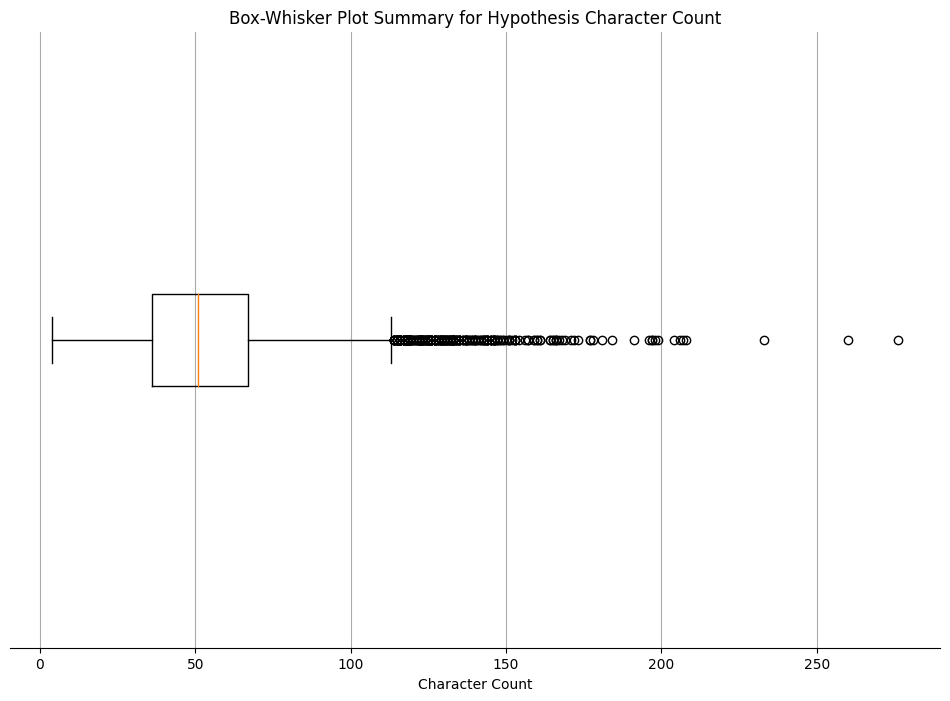

In [12]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_hypothesis_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Hypothesis Character Count")

plt.show()


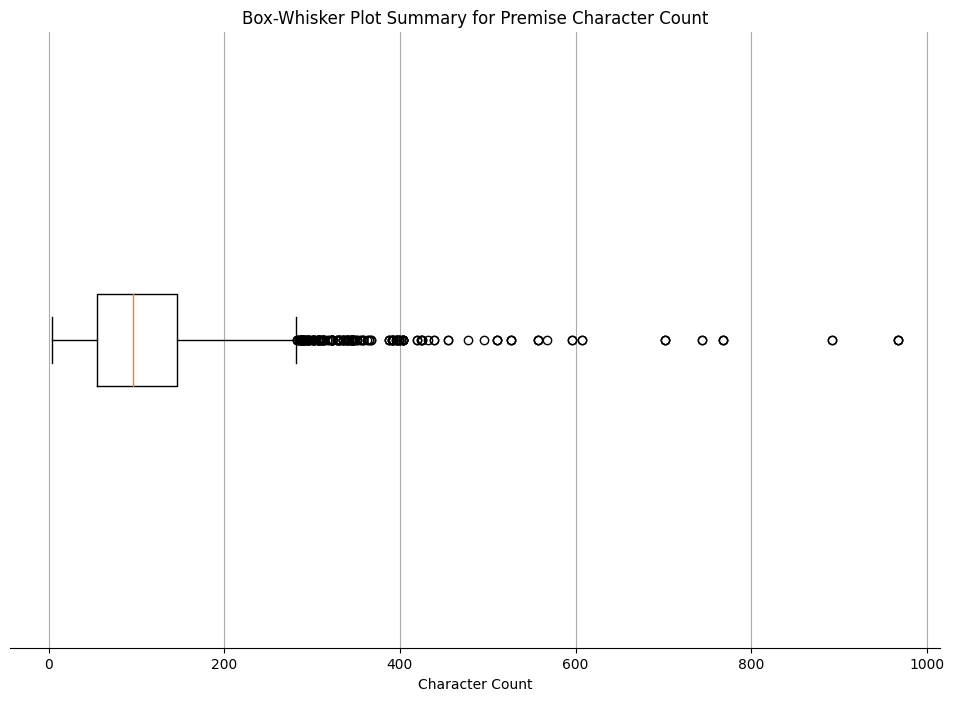

In [13]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_premise_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Premise Character Count")

plt.show()


- From the summary plots of the character counts in the texts, it can be seen that there appear to be many outliers in the distribution. This means that there exists several text elements that are much longer than upper limits of the distribution. This may affect the encoding of the textual embeddings in the model.



- Otherwise, it would seem on average that the premises are longer than the hypotheses.

### Training loop

#### Data preprocessing

In [14]:
def split_labels(x, y):
    return (x[0], x[1]), y


In [15]:
batch_size = 36
buffer_size = batch_size * 10

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            df_train[["hypothesis", "premise"]].values,
            df_train["label"].values
        )
    )
)

train_preprocessed = training_dataset.shuffle(buffer_size=buffer_size).map(split_labels, tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)


#### Model initialization

In [16]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en", sequence_length=195)
bert_train_set = (train_preprocessed.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE))

classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_en", preprocessor=None, num_classes=3)
classifier.compile(optimizer=keras.optimizers.Adam(4e-05), metrics=['accuracy'])
history = classifier.fit(bert_train_set, epochs=5)


Epoch 1/5


I0000 00:00:1731267783.260040     111 service.cc:145] XLA service 0x7ba5940c92e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731267783.260141     111 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731267783.260148     111 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731267880.065929     111 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_628__8', 360 bytes spill stores, 176 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1731267880.192505     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


336/336 ━━━━━━━━━━━━━━━━━━━━ 300s 492ms/step - accuracy: 0.4240 - loss: 1.0516
Epoch 2/5
336/336 ━━━━━━━━━━━━━━━━━━━━ 231s 512ms/step - accuracy: 0.6066 - loss: 0.8345
Epoch 3/5
336/336 ━━━━━━━━━━━━━━━━━━━━ 176s 523ms/step - accuracy: 0.7125 - loss: 0.6440
Epoch 4/5
336/336 ━━━━━━━━━━━━━━━━━━━━ 175s 522ms/step - accuracy: 0.7751 - loss: 0.5048
Epoch 5/5
336/336 ━━━━━━━━━━━━━━━━━━━━ 175s 522ms/step - accuracy: 0.8321 - loss: 0.3920


### Predictions on test data for submission

In [17]:
df_test = pd.read_csv(DATA_DIR +"test.csv")
print(df_test.head())

df_test["label"] = [0] * len(df_test)


           id                                            premise  \
0  c6d58c3f69  بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...   
1  cefcc82292                             هذا هو ما تم نصحنا به.   
2  e98005252c  et cela est en grande partie dû au fait que le...   
3  58518c10ba                   与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp   
4  c32b0d16df                              Она все еще была там.   

                                          hypothesis lang_abv language  
0  کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...       ur     Urdu  
1  عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...       ar   Arabic  
2                             Les mères se droguent.       fr   French  
3                            IMA与其他组织合作，因为它们都依靠共享资金。       zh  Chinese  
4     Мы думали, что она ушла, однако, она осталась.       ru  Russian  


In [18]:
testing_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            df_test[["hypothesis", "premise"]].values,
            df_test["label"].values
        )
    )
)

test_preprocessed = testing_dataset.map(split_labels, tf.data.AUTOTUNE).batch(1, drop_remainder=False).cache().prefetch(tf.data.AUTOTUNE)


In [19]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en", sequence_length=195)

bert_test_set = (test_preprocessed.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE))


In [20]:
predictions = classifier.predict(bert_test_set)
predicted_classes = tf.argmax(predictions, axis=1)
predicted_classes_np = predicted_classes.numpy()
print(predicted_classes_np)


I0000 00:00:1731269358.710691     215 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_99', 88 bytes spill stores, 88 bytes spill loads



5195/5195 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step
[0 2 0 ... 2 0 2]


### Creation of submission file

In [21]:
submission = df_test.id.copy().to_frame()
submission["prediction"] = predicted_classes_np
submission.to_csv("submission.csv", index=False)

submission


,id,prediction
0,c6d58c3f69,0
1,cefcc82292,2
2,e98005252c,0
3,58518c10ba,2
4,c32b0d16df,1
...,...,...
5190,5f90dd59b0,0
5191,f357a04e86,1
5192,1f0ea92118,2
5193,0407b48afb,0
